# SONATA Condition Modifications

This notebook demonstrates how to use SONATA **condition modifications** in BlueCelluLab.

Modifications are defined in the `conditions` block of a SONATA simulation config and allow you to
alter cell properties before the simulation runs. BlueCelluLab supports all five SONATA modification types:

| Type | Description |
|------|-------------|
| `ttx` | Block Na channels (insert TTXDynamicsSwitch) |
| `configure_all_sections` | Apply a statement to all sections of target cells |
| `section_list` | Apply a statement to a named section list (somatic, basal, apical, axonal) |
| `section` | Apply a statement to specific named sections (e.g. apic[10]) |
| `compartment_set` | Apply a statement to segments defined by a compartment set |

See the [SONATA-extension documentation](https://sonata-extension.readthedocs.io/en/latest/sonata_simulation.html#parameters-required-for-modifications) for the full specification.

## 1. Compile mechanisms

As in the previous tutorial, we first compile the NEURON mechanisms.

In [13]:
!nrnivmodl ../mechanisms

/usr/bin/xcrun
/Users/mandge/Desktop/obi/repos/BlueCelluLab/examples/2-sonata-network
Mod files: "../mechanisms/../mechanisms/Ca.mod" "../mechanisms/../mechanisms/CaDynamics_DC0.mod" "../mechanisms/../mechanisms/CaDynamics_E2.mod" "../mechanisms/../mechanisms/Ca_HVA.mod" "../mechanisms/../mechanisms/Ca_HVA2.mod" "../mechanisms/../mechanisms/Ca_LVAst.mod" "../mechanisms/../mechanisms/DetAMPANMDA.mod" "../mechanisms/../mechanisms/DetGABAAB.mod" "../mechanisms/../mechanisms/GluSynapse.mod" "../mechanisms/../mechanisms/Ih.mod" "../mechanisms/../mechanisms/Im.mod" "../mechanisms/../mechanisms/K_Pst.mod" "../mechanisms/../mechanisms/K_Tst.mod" "../mechanisms/../mechanisms/KdShu2007.mod" "../mechanisms/../mechanisms/NaTa_t.mod" "../mechanisms/../mechanisms/NaTg.mod" "../mechanisms/../mechanisms/NaTs2_t.mod" "../mechanisms/../mechanisms/Nap_Et2.mod" "../mechanisms/../mechanisms/ProbAMPANMDA_EMS.mod" "../mechanisms/../mechanisms/ProbGABAAB_EMS.mod" "../mechanisms/../mechanisms/SK_E2.mod" "../me

In [14]:
import json
import logging
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("white")

from bluecellulab import CircuitSimulation
from bluecellulab.circuit.config import SonataSimulationConfig

In [15]:
# Enable INFO logging for the modifications module to see what happens
logging.basicConfig(level=logging.WARNING)
logging.getLogger("bluecellulab.simulation.modifications").setLevel(logging.INFO)

## 2. Examine the simulation config with modifications

In this example, we will use a simulation config that includes five modifications (one of each type) in its `conditions` block.

In [16]:
sim_config_path = Path("sim_quick_scx_sonata_multicircuit") / "simulation_config_modifications.json"

with open(sim_config_path) as f:
    config_dict = json.load(f)

print(json.dumps(config_dict["conditions"], indent=4))

{
    "v_init": -65,
    "modifications": [
        {
            "name": "TTX_block_NodeB",
            "type": "ttx",
            "node_set": "Mosaic_B"
        },
        {
            "name": "double_cm_all",
            "type": "configure_all_sections",
            "node_set": "Mosaic_A",
            "section_configure": "%s.cm = 2.0"
        },
        {
            "name": "scale_soma_cm",
            "type": "section_list",
            "node_set": "Mosaic_A",
            "section_configure": "somatic.cm *= 1.5"
        },
        {
            "name": "set_apic0_cm",
            "type": "section",
            "node_set": "Mosaic_A",
            "section_configure": "apic[0].cm = 5.0"
        },
        {
            "name": "set_compartment_cm",
            "type": "compartment_set",
            "compartment_set": "Mosaic_A",
            "section_configure": "cm = 10.0"
        }
    ]
}


The five modifications are:

1. **`TTX_block_NodeB`** (`ttx`): Blocks Na channels on all cells in the `Mosaic_B` node set by inserting `TTXDynamicsSwitch`.
2. **`double_cm_all`** (`configure_all_sections`): Sets membrane capacitance (`cm = 2.0`) on **all** sections of `Mosaic_A` cells.
3. **`scale_soma_cm`** (`section_list`): Further scales `cm` by 1.5x on only the **somatic** sections of `Mosaic_A` cells.
4. **`set_apic0_cm`** (`section`): Sets `cm = 5.0` on the specific section `apic[0]` of `Mosaic_A` cells. Cells without `apic[0]` are gracefully skipped.
5. **`set_compartment_cm`** (`compartment_set`): Sets `cm = 10.0` on specific segments defined in `compartment_sets.json` (soma[0] of node 0 at x=0.5, section 2 of node 1 at x=0.3).

Modifications are applied in order. After all five, the expected `cm` values for NodeA cells are:
- **soma[0]** of node 0: 10.0 (set to 2.0, then ×1.5=3.0, then overwritten to 10.0 by compartment_set)
- **soma[0]** of nodes 1,2: 3.0 (set to 2.0, then ×1.5)
- **apic[0]**: 5.0 (set to 2.0, then overwritten to 5.0 by section modification)
- **other dendrites**: 2.0

## 3. Parse modifications with BlueCelluLab

BlueCelluLab parses the modifications into typed dataclasses via `get_modifications()`.

In [17]:
sonata_config = SonataSimulationConfig(sim_config_path)
modifications = sonata_config.get_modifications()

for mod in modifications:
    print(f"{mod.name}: type={mod.type}, class={type(mod).__name__}")
    if hasattr(mod, 'section_configure'):
        print(f"section_configure: {mod.section_configure}")
    if hasattr(mod, 'node_set'):
        print(f"node_set: {mod.node_set}")
    if hasattr(mod, 'compartment_set'):
        print(f"compartment_set: {mod.compartment_set}")

TTX_block_NodeB: type=ttx, class=ModificationTTX
node_set: Mosaic_B
double_cm_all: type=configure_all_sections, class=ModificationConfigureAllSections
section_configure: %s.cm = 2.0
node_set: Mosaic_A
scale_soma_cm: type=section_list, class=ModificationSectionList
section_configure: somatic.cm *= 1.5
node_set: Mosaic_A
set_apic0_cm: type=section, class=ModificationSection
section_configure: apic[0].cm = 5.0
node_set: Mosaic_A
set_compartment_cm: type=compartment_set, class=ModificationCompartmentSet
section_configure: cm = 10.0
compartment_set: Mosaic_A


## 4. Run simulation with modifications

When `CircuitSimulation.instantiate_gids()` is called, modifications are automatically applied after cells are created but before synapses and stimuli are added. This matches the ordering used by [neurodamus](https://github.com/openbraininstitute/neurodamus).

The INFO-level logs show exactly which modifications were applied and to how many sections/cells.

In [18]:
sim = CircuitSimulation(sim_config_path)

In [19]:
from bluepysnap import Simulation as snap_sim
import pandas as pd

snap_access = snap_sim(sim_config_path)
all_nodes = pd.concat([x[1] for x in snap_access.circuit.nodes.get()])
all_cell_ids = all_nodes.index.to_list()
print(f"All cells in circuit: {all_cell_ids}")

All cells in circuit: [('NodeA', 0), ('NodeA', 1), ('NodeA', 2), ('NodeB', 0), ('NodeB', 1)]


In [20]:
# Instantiate all cells — modifications are applied automatically
sim.instantiate_gids(all_cell_ids, add_stimuli=False, add_synapses=False)

INFO:bluecellulab.simulation.modifications:Applying modification 'TTX_block_NodeB' (type=ttx) to node_set 'Mosaic_B'
INFO:bluecellulab.simulation.modifications:Modification 'TTX_block_NodeB' (ttx): enabled on 2 cells
INFO:bluecellulab.simulation.modifications:Applying modification 'double_cm_all' (type=configure_all_sections) to node_set 'Mosaic_A'
INFO:bluecellulab.simulation.modifications:Modification 'double_cm_all' applied to 269 sections across 3 cells
INFO:bluecellulab.simulation.modifications:Applying modification 'scale_soma_cm' (type=section_list) to node_set 'Mosaic_A'
INFO:bluecellulab.simulation.modifications:Modification 'scale_soma_cm' applied to 3 sections across 3 cells
INFO:bluecellulab.simulation.modifications:Applying modification 'set_apic0_cm' (type=section) to node_set 'Mosaic_A'
INFO:bluecellulab.simulation.modifications:Modification 'set_apic0_cm' applied to 2 sections across 2 cells
INFO:bluecellulab.simulation.modifications:Applying modification 'set_compartme

## 5. Verify modifications were applied

Let's inspect the cells to confirm the modifications took effect.

In [21]:
print("=" * 70)
print("Verifying all 5 modification types on Mosaic_A cells")
print("=" * 70)

for cell_id in sim.cells:
    cell = sim.cells[cell_id]
    pop = cell_id.population_name
    nid = cell_id.id
    print(f"\nCell {cell_id}:")

    # Check soma cm
    soma = cell.sections.get("soma[0]")
    if soma:
        print("soma[0] cm = {soma.cm}")

    # Check apic[0] cm (section modification)
    apic0 = cell.sections.get("apic[0]")
    if apic0:
        print("apic[0] cm = {apic0.cm}")
    elif pop == "NodeA":
        print("apic[0]: not present (section mod was skipped)")

    # Check a dendritic section cm
    dend0 = cell.sections.get("dend[0]")
    if dend0:
        print("dend[0] cm = {dend0.cm}")

Verifying all 5 modification types on Mosaic_A cells

Cell CellId(population_name='NodeA', id=0):
soma[0] cm = {soma.cm}
apic[0] cm = {apic0.cm}
dend[0] cm = {dend0.cm}

Cell CellId(population_name='NodeA', id=1):
soma[0] cm = {soma.cm}
apic[0]: not present (section mod was skipped)
dend[0] cm = {dend0.cm}

Cell CellId(population_name='NodeA', id=2):
soma[0] cm = {soma.cm}
apic[0] cm = {apic0.cm}
dend[0] cm = {dend0.cm}

Cell CellId(population_name='NodeB', id=0):
soma[0] cm = {soma.cm}
dend[0] cm = {dend0.cm}

Cell CellId(population_name='NodeB', id=1):
soma[0] cm = {soma.cm}
dend[0] cm = {dend0.cm}


## 6. Compare: with vs without modifications

To see the effect of modifications on simulation output, let's run two simulations
side by side — one with and one without modifications — and compare the voltage traces.

In [22]:
# Simulation WITH modifications (already instantiated above)
sim.run(t_stop=100.0)
traces_with_mods = {}
for cell_id in sim.cells:
    traces_with_mods[cell_id] = {
        "time": sim.get_time_trace(),
        "voltage": sim.get_voltage_trace(cell_id),
    }

In [23]:
# Simulation WITHOUT modifications (baseline)
baseline_config = Path("sim_quick_scx_sonata_multicircuit") / "simulation_config_noinput.json"
sim_baseline = CircuitSimulation(baseline_config)
sim_baseline.instantiate_gids(all_cell_ids, add_stimuli=False, add_synapses=False)
sim_baseline.run(t_stop=100.0)
traces_baseline = {}
for cell_id in sim_baseline.cells:
    traces_baseline[cell_id] = {
        "time": sim_baseline.get_time_trace(),
        "voltage": sim_baseline.get_voltage_trace(cell_id),
    }

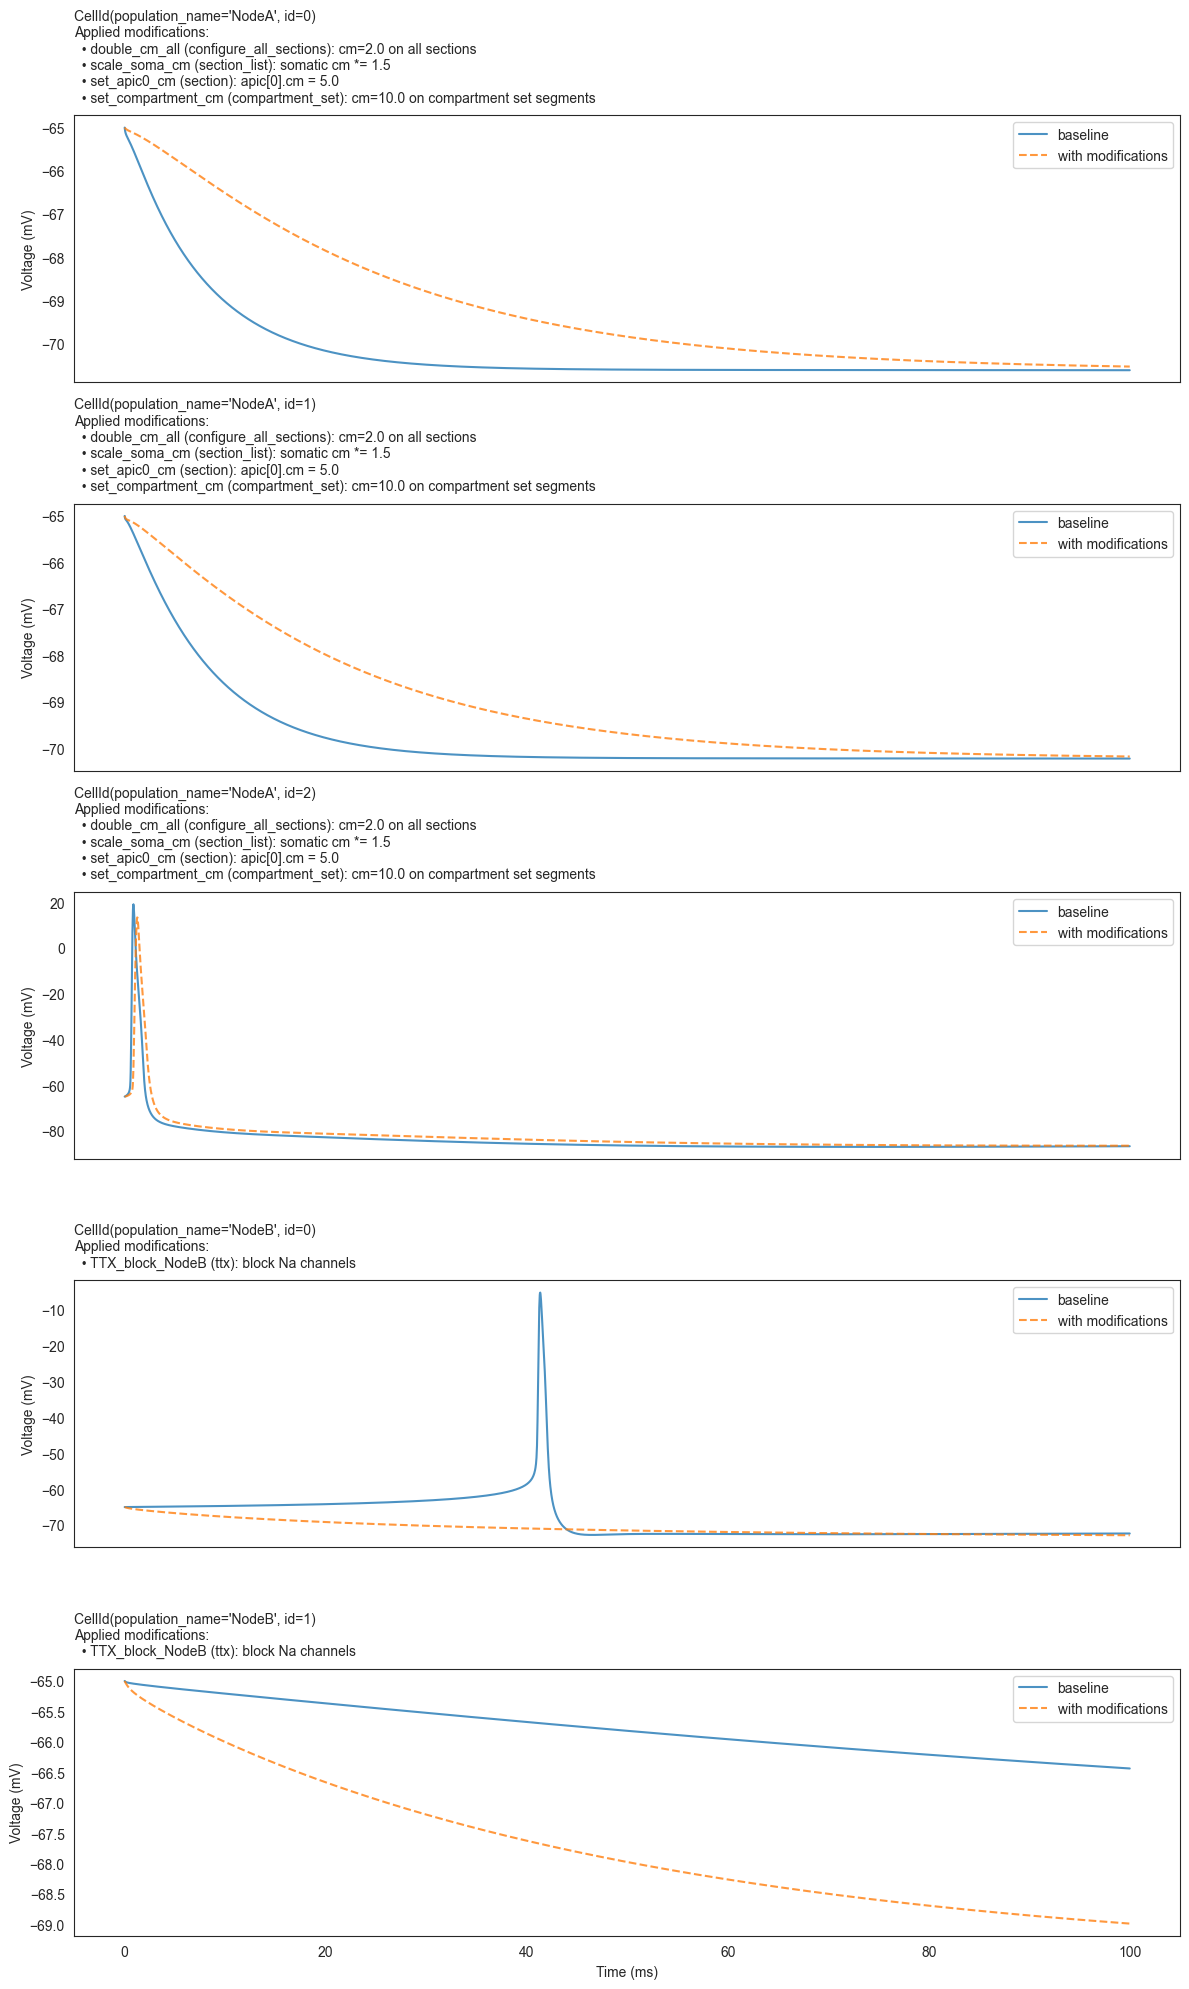

In [24]:
# Build a per-cell summary of which modifications were applied
# (based on the config's node_set / compartment_set targeting)
mod_descriptions = {
    "TTX_block_NodeB": ("ttx", "Mosaic_B", "block Na channels"),
    "double_cm_all": ("configure_all_sections", "Mosaic_A", "cm=2.0 on all sections"),
    "scale_soma_cm": ("section_list", "Mosaic_A", "somatic cm *= 1.5"),
    "set_apic0_cm": ("section", "Mosaic_A", "apic[0].cm = 5.0"),
    "set_compartment_cm": ("compartment_set", "Mosaic_A", "cm=10.0 on compartment set segments"),
}

# Map population names to the node_set they belong to
pop_to_nodeset = {"NodeA": "Mosaic_A", "NodeB": "Mosaic_B"}

def get_mods_for_cell(cell_id):
    """Return a list of short modification descriptions for a given cell."""
    nodeset = pop_to_nodeset.get(cell_id.population_name, "")
    labels = []
    for mod_name, (mod_type, target, desc) in mod_descriptions.items():
        if target == nodeset:
            labels.append(f"{mod_name} ({mod_type}): {desc}")
    if not labels:
        labels.append("none")
    return labels

# Plot comparison with per-cell modification labels
fig, axes = plt.subplots(len(sim.cells), 1, figsize=(12, 4 * len(sim.cells)), sharex=True)
if len(sim.cells) == 1:
    axes = [axes]

for ax, cell_id in zip(axes, sim.cells):
    if cell_id in traces_baseline:
        ax.plot(traces_baseline[cell_id]["time"], traces_baseline[cell_id]["voltage"],
                label="baseline", alpha=0.8)
    if cell_id in traces_with_mods:
        ax.plot(traces_with_mods[cell_id]["time"], traces_with_mods[cell_id]["voltage"],
                label="with modifications", alpha=0.8, linestyle="--")
    ax.set_ylabel("Voltage (mV)")

    # Build a descriptive title showing which modifications apply
    mods_list = get_mods_for_cell(cell_id)
    mods_text = "\n".join(f"  • {m}" for m in mods_list)
    ax.set_title(f"{cell_id}\nApplied modifications:\n{mods_text}",
                 fontsize=10, loc="left", pad=10)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
# plt.savefig("ex2_modifications_comparison.pdf")
plt.show()

## 7. Graceful skipping behavior

An important design decision: modifications **skip** sections or cells that don't match,
rather than failing. This is essential because `node_set` targets can contain heterogeneous
cells (e.g., some with apical dendrites, some without).

- Sections missing a referenced attribute are silently skipped
- If zero sections matched, a warning is logged
- Invalid `section_configure` syntax still raises an error

This matches [neurodamus's behavior](https://github.com/openbraininstitute/neurodamus) for `configure_all_sections`
and extends it consistently to the new types (`section_list`, `section`, `compartment_set`).

## Summary

- Modifications are defined in `conditions.modifications` of the SONATA simulation config
- BlueCelluLab parses them via `SonataSimulationConfig.get_modifications()`
- They are automatically applied during `CircuitSimulation.instantiate_gids()`, after cell creation
- All five types are supported: `ttx`, `configure_all_sections`, `section_list`, `section`, `compartment_set`
- Logging at INFO level shows what was applied; WARNING level flags zero-match cases